In [1]:
import pandas as pd
import numpy as np

## Data overview

### Input data structure

In [2]:
#rides dataframe has rides data
rides_df = pd.read_csv('../input/metro-bike-share-trip-data.csv')
#stations df has station level data
stations_df = pd.read_csv('../input/metro-bike-share-stations-2017-02-09.csv')

/home/sgamez/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
rides_df.head(5)

Trip ID  Duration           Start Time             End Time  \
0  1912818       180  2016-07-07T04:17:00  2016-07-07T04:20:00   
1  1919661      1980  2016-07-07T06:00:00  2016-07-07T06:33:00   
2  1933383       300  2016-07-07T10:32:00  2016-07-07T10:37:00   
3  1944197     10860  2016-07-07T10:37:00  2016-07-07T13:38:00   
4  1940317       420  2016-07-07T12:51:00  2016-07-07T12:58:00   

   Starting Station ID  Starting Station Latitude  Starting Station Longitude  \
0               3014.0                  34.056610                  -118.23721   
1               3014.0                  34.056610                  -118.23721   
2               3016.0                  34.052898                  -118.24156   
3               3016.0                  34.052898                  -118.24156   
4               3032.0                  34.049889                  -118.25588   

   Ending Station ID  Ending Station Latitude  Ending Station Longitude  \
0             3014.0                34.056610                -118.23721   
1             3014.0                34.056610                -118.23721   
2             3016.0                34.052898                -118.24156   
3             3016.0                34.052898                -118.24156   
4             3032.0                34.049889                -118.25588   

   Bike ID  Plan Duration Trip Route Category Passholder Type  \
0   6281.0           30.0          Round Trip    Monthly Pass   
1   6281.0           30.0          Round Trip    Monthly Pass   
2   5861.0          365.0          Round Trip       Flex Pass   
3   5861.0          365.0          Round Trip       Flex Pass   
4   6674.0            0.0          Round Trip         Walk-up   

                                   Starting Lat-Long  \
0  {'longitude': '-118.23721', 'latitude': '34.05...   
1  {'longitude': '-118.23721', 'latitude': '34.05...   
2  {'longitude': '-118.24156', 'latitude': '34.05...   
3  {'longitude': '-118.24156', 'latitude': '34.05...   
4  {'longitude': '-118.25588', 'latitude': '34.04...   

                                     Ending Lat-Long  
0  {'longitude': '-118.23721', 'latitude': '34.05...  
1  {'longitude': '-118.23721', 'latitude': '34.05...  
2  {'longitude': '-118.24156', 'latitude': '34.05...  
3  {'longitude': '-118.24156', 'latitude': '34.05...  
4  {'longitude': '-118.25588', 'latitude': '34.04...

In [4]:
stations_df.head(5)
#Go_live_date format changes? :(

Station_ID     Station_Name  Go_live_date Region  Status
0        3000  Virtual Station   2016-07-07     NaN  Active
1        3005     7th & Flower      7/7/2016   DTLA  Active
2        3006      Olive & 8th      7/7/2016   DTLA  Active
3        3007      5th & Grand      7/7/2016   DTLA  Active
4        3008   Figueroa & 9th      7/7/2016   DTLA  Active

## High level analysis & data preparation

In [5]:
rides_df.columns

Index(['Trip ID', 'Duration', 'Start Time', 'End Time', 'Starting Station ID',
       'Starting Station Latitude', 'Starting Station Longitude',
       'Ending Station ID', 'Ending Station Latitude',
       'Ending Station Longitude', 'Bike ID', 'Plan Duration',
       'Trip Route Category', 'Passholder Type', 'Starting Lat-Long',
       'Ending Lat-Long'],
      dtype='object')

In [6]:
#first, remove spaces in columns names, so it is easier to work with pandas 
rides_df.columns = [c.replace(' ', '_').lower() for c in rides_df.columns]
stations_df.columns = [c.replace(' ', '_').lower() for c in stations_df.columns]

In [7]:
#merge starting station name
rides_df = rides_df.rename(columns={'starting_station_id': 'station_id'})
rides_df = rides_df.merge(stations_df[['station_id', 'station_name', 'region']], on='station_id', how='left')
rides_df = rides_df.rename(columns={'station_id': 'starting_station_id',
                                    'station_name': 'station_name_start',
                                    'region': 'region_start'})
#merge ending station name
rides_df = rides_df.rename(columns={'ending_station_id': 'station_id'})
rides_df = rides_df.merge(stations_df[['station_id', 'station_name', 'region']], on='station_id', how='left')
rides_df = rides_df.rename(columns={'station_id': 'ending_station_id',
                                    'station_name': 'station_name_end',
                                    'region': 'region_end'})

In [8]:
rides_df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'starting_station_id',
       'starting_station_latitude', 'starting_station_longitude',
       'ending_station_id', 'ending_station_latitude',
       'ending_station_longitude', 'bike_id', 'plan_duration',
       'trip_route_category', 'passholder_type', 'starting_lat-long',
       'ending_lat-long', 'station_name_start', 'region_start',
       'station_name_end', 'region_end'],
      dtype='object')

### How many trips and stations do we have in the dataset? 

In [9]:
rides_df.trip_id.nunique()

132427

In [10]:
#just to check that table is unique at trip level
#and it is
rides_df.shape[0]

132427

In [11]:
#does not exactly match, so i guess we could say we have only 67 stations in our dataset
rides_df.starting_station_id.nunique(), stations_df.shape[0]

(67, 129)

### What is the average duration of each trip?

In [12]:
#Duration column, as informed in https://bikeshare.metro.net/about/data/ is in minutes
#The average trip length is 1555.3 minutes (25.9 hours)???
#The median trip length is 600 minutes (10 hours)???
#These numbers strikes me quite a bit, how is this possible?
rides_df.duration.mean(), rides_df.duration.median()

(1555.3015623702115, 600.0)

In [13]:
#lets look again at the data
rides_df[['duration', 'start_time', 'end_time']].head(5)

duration           start_time             end_time
0       180  2016-07-07T04:17:00  2016-07-07T04:20:00
1      1980  2016-07-07T06:00:00  2016-07-07T06:33:00
2       300  2016-07-07T10:32:00  2016-07-07T10:37:00
3     10860  2016-07-07T10:37:00  2016-07-07T13:38:00
4       420  2016-07-07T12:51:00  2016-07-07T12:58:00

So, we can see that looking at start times, and end times, the duration seems to be measured not in minutes, but in seconds, that makes a bit more of sense to me!

In [14]:
#duration (in minuts) column
rides_df['duration_mins'] = rides_df.duration / 60.
rides_df.duration_mins.mean(), rides_df.duration_mins.median()

(25.92169270617019, 10.0)

In [15]:
#Let's look at the data distribution...
rides_df.duration_mins.hist()

There are extreme values in the dataset, 1400 minutes (23.3 hours) ride seems quite too high! 
Also, reading from the bikeshare page: "Some short round trips or long trips may be the result of system or user error, but have been kept in the dataset for completeness".

In [16]:
#lets remove entries with more than hours of duration
rides_clean = rides_df[rides_df.duration_mins < 180]
rides_clean.shape[0], rides_df.shape[0] - rides_clean.shape[0]

(130109, 2318)

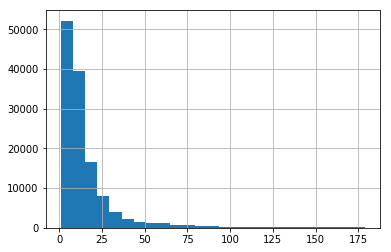

In [17]:
rides_clean.duration_mins.hist(bins=25)

Now that we have removed extremely large duration trips, let's look at extremely short trips.

In [18]:
rides_clean.duration_mins.quantile(q=[0, 0.01, 0.05])

0.00    1.0
0.01    2.0
0.05    3.0
Name: duration_mins, dtype: float64

We have trips with one minute length (someone who picks a bike and decides to leave it back?). Also, 5% of the trips have duration lower than 3 minutes. To asses whether if it is too short, let's look at the distance (in straight line) between starting and ending stations. But first, less assess the quality of the input coordinates.

In [19]:
#NA entries?
rides_clean[['starting_station_longitude', 'starting_station_latitude',\
                                            'ending_station_longitude','ending_station_latitude']].isna().sum()

starting_station_longitude     45
starting_station_latitude      45
ending_station_longitude      370
ending_station_latitude       370
dtype: int64

In [20]:
#remove NA entries
rides_clean = rides_clean.loc[(rides_clean.starting_station_longitude.notna()) & \
                              (rides_clean.ending_station_longitude.notna())]

In [21]:
#Entries with lon / lat set to 0?
(rides_clean[['starting_station_longitude', 'starting_station_latitude',\
                                            'ending_station_longitude','ending_station_latitude']]==0).sum()

starting_station_longitude    31
starting_station_latitude     31
ending_station_longitude      44
ending_station_latitude       44
dtype: int64

In [22]:
#station 4108 is either a station located here: https://www.latlong.net/c/?lat=0.000000&long=0.000000
#or it is some kind of auxilair station
rides_clean.loc[rides_clean.starting_station_longitude==0, 'starting_station_id'].unique()

array([4108.0], dtype=object)

In [23]:
stations_df.loc[stations_df.station_id == 4108]

station_id    station_name go_live_date region    status
66        4108  1 LA warehouse     7/7/2016   DTLA  Inactive

Aha! So it is the LA warehouse. I would say that it is also interesting to remove trips starting or ending in the warehouse.

In [25]:
#Remove entries starting or ending in the warehouse
rides_clean = rides_clean.loc[~((rides_clean.starting_station_id == 4108) \
                                | (rides_clean.ending_station_id == 4108))]

Now that the 0s issues is shorted out, let's follow with the distance calculation.

In [26]:
#Haversine distance
#from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians

def hav_distance(row):
    """
    Calculates the haversine distance, given a pandas row with the following row format:
    lon1, lat1, lon2, lat2
    
    Returns the distance in KM.
    """
    # approximate radius of earth in km
    R = 6373.0

    dlon = radians(row[2]) - radians(row[0])
    dlat = radians(row[3]) - radians(row[1])

    a = sin(dlat / 2)**2 + cos(radians(row[1])) * cos(radians(row[3])) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [27]:
rides_clean['trip_distance'] = rides_clean[['starting_station_longitude', 'starting_station_latitude',\
                                            'ending_station_longitude','ending_station_latitude']]\
                                          .apply(hav_distance, axis=1)

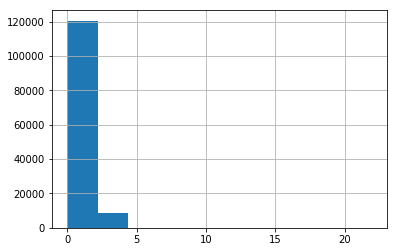

In [28]:
#distance distribution
rides_clean.trip_distance.hist()

In [29]:
rides_clean.loc[rides_clean.duration_mins < 3].trip_distance.head(10)

13     0.000000
29     0.000000
32     0.000000
155    0.366738
156    0.366738
173    0.000000
202    0.543915
416    0.000000
478    0.000000
479    0.000000
Name: trip_distance, dtype: float64

Yup, it seems that there are many trips with 0 distance. I do not think that all of them should be removed, as some of them can be 'round trips'.

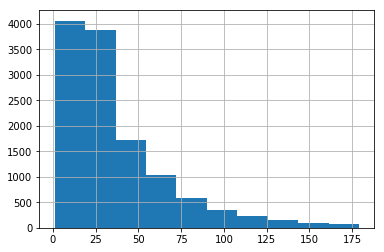

In [30]:
rides_clean.loc[rides_clean.trip_distance == 0].duration_mins.hist()

In [31]:
rides_clean.loc[rides_clean.trip_distance == 0].trip_route_category.value_counts()

Round Trip    12217
One Way           1
Name: trip_route_category, dtype: int64

Yup, most of them are round trips, and data distribution seems quite ok

In [32]:
#mislabeled entry?
#I don't know what is the round trip definition, but this looks quite round trip to me
rides_clean.loc[rides_clean.trip_distance == 0].loc[rides_clean.trip_route_category=='One Way'][['starting_station_id', 'ending_station_id']]

starting_station_id ending_station_id
125823                3039              3039

So, after all of this, I think it would be interesting to remove rides with 0 distance and duration lower than 2 minutes.

In [33]:
rides_clean = rides_clean.loc[~((rides_clean.duration_mins <= 2) & (rides_clean.trip_distance == 0))]

In [34]:
rides_clean.shape[0], rides_df.shape[0] - rides_clean.shape[0]
#we have filtered out 3.5K rides from since the beginning...

(128501, 3926)

Before closing the duration topic, what is the trip_distance - duration (speed) looks like in our trips?

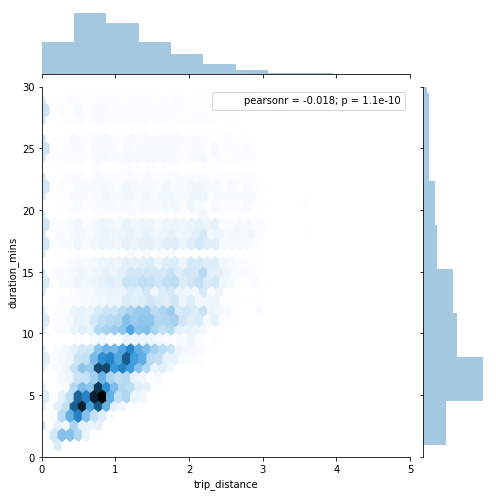

In [35]:
import seaborn as sns
sns.jointplot(x=rides_clean.trip_distance,
              y=rides_clean.duration_mins,kind='hex', 
              size = 7, 
              joint_kws=dict(gridsize=200),
              xlim=(0, 5),
              ylim=(0, 30))

Interesting, we can that round trips are 'breaking' the correlation estimation, as no matter the duration, they will always have 0 distance. But in the other samples we could fit a line and get the average speed.

In [36]:
#calculate avg speed
#Initialized to 0, so that when we are in a Round trip we do not get a divided by 0 
rides_clean['avg_speed'] = 0
#one way indeces
ow_idx = rides_clean.loc[rides_clean.trip_route_category != 'Round Trip'].index
rides_clean.loc[ow_idx, 'avg_speed'] = rides_clean.loc[ow_idx, 'trip_distance'] / (rides_clean.loc[ow_idx, 'duration_mins'] / 60.0)
rides_clean.loc[ow_idx].avg_speed.mean()

7.136364928215828

7.14 KM/h seems reasonable. (According to Google, the average cycling speed in Copenhagen is 15.5 km/h)

### Starting Time analysis

In [37]:
#format is ISO 8601 (info from the webpage)
rides_clean['start_time'].head(5)

0    2016-07-07T04:17:00
1    2016-07-07T06:00:00
2    2016-07-07T10:32:00
4    2016-07-07T12:51:00
5    2016-07-07T12:51:00
Name: start_time, dtype: object

In [38]:
#as datetime
rides_clean['start_time_dt'] = pd.to_datetime(rides_clean.start_time)
rides_clean['end_time_dt'] = pd.to_datetime(rides_clean.end_time)
rides_clean[['start_time', 'start_time_dt']].head(5)
#the transformation looks all right

start_time       start_time_dt
0  2016-07-07T04:17:00 2016-07-07 04:17:00
1  2016-07-07T06:00:00 2016-07-07 06:00:00
2  2016-07-07T10:32:00 2016-07-07 10:32:00
4  2016-07-07T12:51:00 2016-07-07 12:51:00
5  2016-07-07T12:51:00 2016-07-07 12:51:00

In [39]:
#Extract year, month, day, and day of the week from the datetime column 
rides_clean['year'] = rides_clean.start_time_dt.dt.year
rides_clean['month'] = rides_clean.start_time_dt.dt.month
rides_clean['day'] = rides_clean.start_time_dt.dt.day
#The day of the week with Monday=0, Sunday=6
rides_clean['dayweek'] = rides_clean.start_time_dt.dt.dayofweek

In [40]:
rides_clean.start_time_dt.min()

Timestamp('2016-07-07 04:17:00')

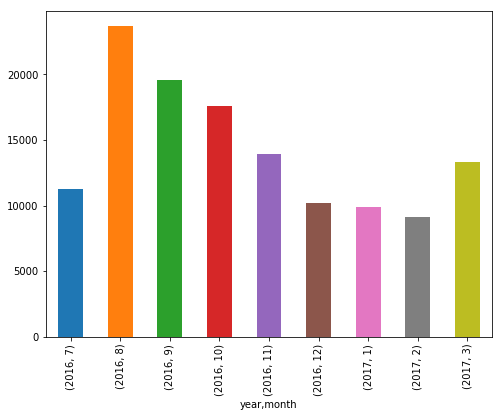

In [41]:
rides_clean.groupby(['year', 'month'])['trip_id'].count().plot.bar(figsize = (8, 6))

The highest number of trips were during August 2016. This high volume might have been related to good weather, tourism and that most of the people have summer vacations during that month. After August the volume reduced, reaching to around 10K monthly trips from December to February. In march we can see a increase in the volume.

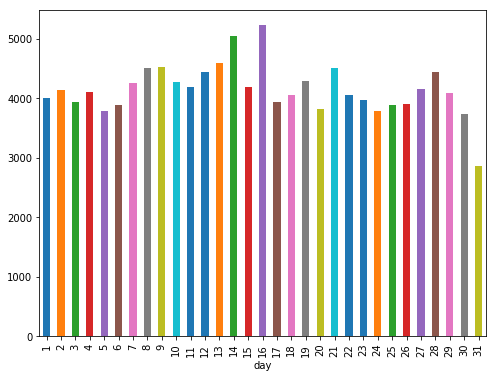

In [42]:
rides_clean.groupby(['day'])['trip_id'].count().plot.bar(figsize = (8, 6))

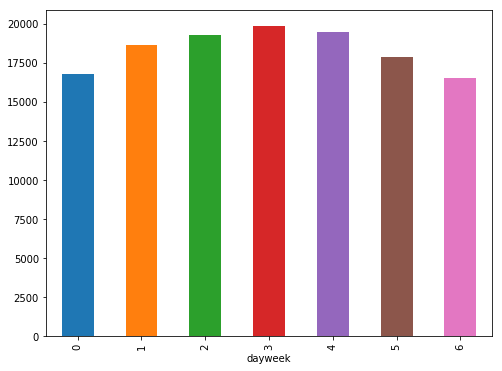

In [43]:
rides_clean.groupby(['dayweek'])['trip_id'].count().plot.bar(figsize = (8, 6))

It is interesting to see that the day of the week with the highest trip volume is on Thursday

### Station trip volume analysis

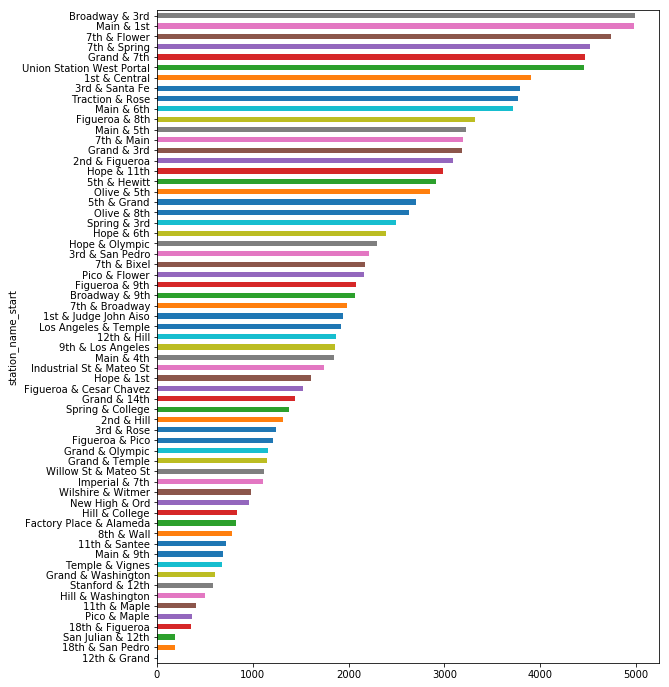

In [44]:
rides_clean.groupby(['station_name_start'])['trip_id'].count().sort_values().plot.barh(figsize = (9, 12))

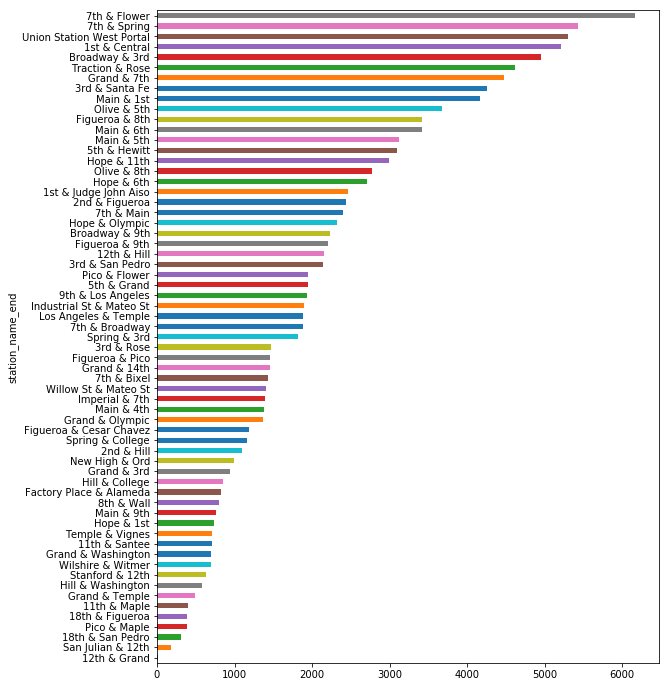

In [45]:
rides_clean.groupby(['station_name_end'])['trip_id'].count().sort_values().plot.barh(figsize = (9, 12))

### Route frequency analysis

In [46]:
rides_clean['route'] = rides_clean.station_name_start + '-->' + rides_clean.station_name_end

In [47]:
#we have 3585 routes, lets plot top 50
rides_clean.route.nunique()

3514

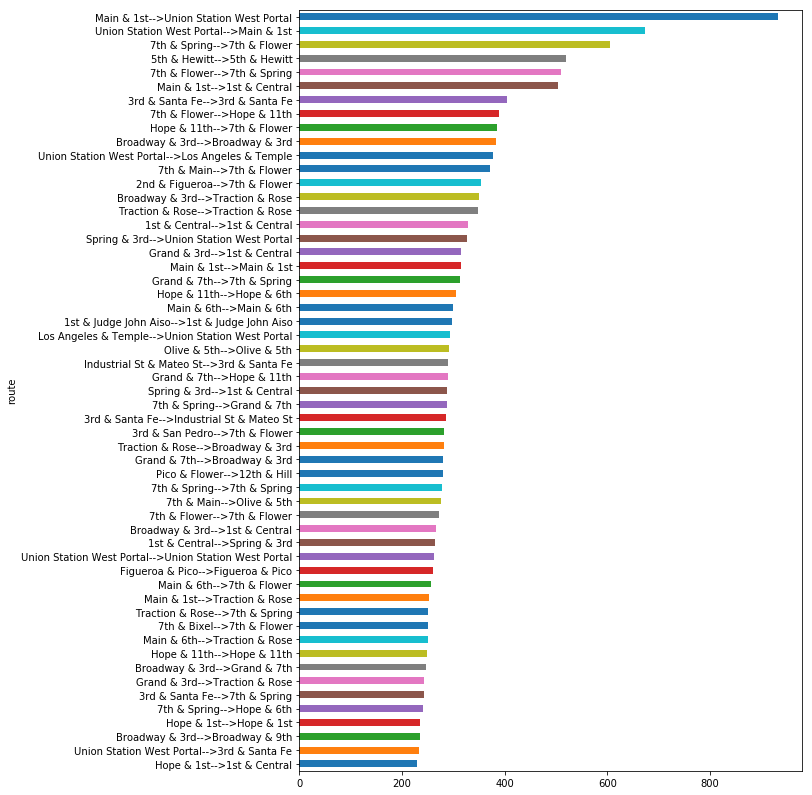

In [48]:
rides_clean.groupby(['route'])['trip_id'].count().sort_values()[-55:].plot.barh(figsize = (9, 14))

It is interesting to see that the 'Main & 1st-->Union Station West Portal' route is top one while the same route, in opposite direction has a significant lower volume (is it downhill in one direction?)

## Geographical visualization

### base map

In [310]:
#we will use folium, nice package for geographical data
import folium

def get_base_map(rides_clean):
    return folium.Map(location=[rides_clean.starting_station_latitude.mean(),
                             rides_clean.starting_station_longitude.mean()],
                   zoom_start=14,
                   tiles='cartodbpositron')

#base map
base = get_base_map(rides_clean)
base

### Station locations

In [311]:
def add_station_markers(initial_map, rides_clean):
    #station location visualization
    statdf = rides_clean.drop_duplicates(subset=['starting_station_id'])
    out_map = initial_map
    for lat, lon, name in zip(statdf['starting_station_latitude'], statdf['starting_station_longitude'], statdf['station_name_start']):
        out_map.add_child(folium.Marker(location=[lat,lon], popup=(folium.Popup(name))))
    return out_map

markers = add_station_markers(base, rides_clean)
markers

### Station & top routes, taking into account both directions for every route

In [312]:
#groupby route
route_cnt = pd.DataFrame(rides_clean.groupby(['station_name_start', 'station_name_end', 'route'])['trip_id'].count()).reset_index()
route_cnt_swap = route_cnt.rename(columns = {'station_name_start': 'station_name_end',
                                             'station_name_end': 'station_name_start'})
#merge data for the routes, taking into account both directions
route_cnt_all = route_cnt.merge(route_cnt_swap, on=['station_name_start', 'station_name_end'])
#sum the trips count if it has two directions (do not sum twice round trips)
route_cnt_all['route_count'] = route_cnt_all['trip_id_x']
update_idx = route_cnt_all.station_name_start != route_cnt_all.station_name_end
route_cnt_all.loc[update_idx, 'route_count'] = route_cnt_all[update_idx].trip_id_x + route_cnt_all[update_idx].trip_id_y 
route_cnt_all.head(5)

station_name_start  station_name_end                          route_x  \
0       11th & Maple      11th & Maple      11th & Maple-->11th & Maple   
1       11th & Maple     11th & Santee     11th & Maple-->11th & Santee   
2       11th & Maple       12th & Hill       11th & Maple-->12th & Hill   
3       11th & Maple   18th & Figueroa   11th & Maple-->18th & Figueroa   
4       11th & Maple  18th & San Pedro  11th & Maple-->18th & San Pedro   

   trip_id_x                          route_y  trip_id_y  route_count  
0        117      11th & Maple-->11th & Maple        117          117  
1         13     11th & Santee-->11th & Maple          6           19  
2          1       12th & Hill-->11th & Maple          9           10  
3          2   18th & Figueroa-->11th & Maple          2            4  
4          2  18th & San Pedro-->11th & Maple          4            6

In [313]:
#final steps, and filter only those with a volume > 200
route_cnt_all = route_cnt_all.rename(columns = {'route_x': 'route'})
routedf = rides_clean.drop_duplicates(subset=['route'])
routedf = routedf.merge(route_cnt_all, on = 'route')
routedf_vol = routedf.loc[routedf.route_count > 200]
def draw_route_lines(initial_map, routedf_vol):
    out_map = initial_map
    #draw every route as a line
    for ix, row  in routedf_vol[['starting_station_latitude', 'starting_station_longitude', 'ending_station_latitude', 'ending_station_longitude', 'route_count']].iterrows():
        #draw a line for every route
        folium.PolyLine([(row['starting_station_latitude'], row['starting_station_longitude']), \
                         (row['ending_station_latitude'], row['ending_station_longitude'])],
                         weight = row['route_count'] / 150.,
                         opacity = float(row['route_count']) / routedf_vol['route_count'].max(),
                         popup= str(int(row['route_count'])))\
              .add_to(out_map)
    return out_map

draw_route_lines(markers, routedf_vol)

In [314]:
#I would like to have done something like this:
#https://python-graph-gallery.com/300-draw-a-connection-line/
#but it did not seem so simple with folium :(

### Rides HeatMap

In [316]:
from folium import plugins
#mostly taken from https://alysivji.github.io/getting-started-with-folium.html
# convert to (n, 2) nd-array format for heatmap
#limited to 40K obs, as with more than that it dies
stationArr = rides_clean[['starting_station_latitude', 'starting_station_longitude']][:40000].as_matrix()
# plot heatmap
# - get base map
# - then draw the actual HeatMap
get_base_map(rides_clean).add_child(plugins.HeatMap(stationArr, radius=40, max_val=300))

In [317]:
#same as before, but adding route lines
(draw_route_lines(get_base_map(rides_clean), routedf_vol)).add_child(plugins.HeatMap(stationArr, radius=40, max_val=300))